In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

import imutils
from imutils.video import VideoStream

import mtcnn
from mtcnn.mtcnn import MTCNN

# Begin  Detection

* Load a pre-trained face detection model to extract faces from images.
* Run our mask detector to detect masks for each of the faces

Here, we will be trying 2 different pre-trained face detector


In [3]:
imgSize = 224

In [4]:
#Face Detector Type 1
"""
CascadeClassifier: https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html
Github: https://github.com/opencv/opencv/tree/master/data/haarcascades

We will load the configuration xml and then use Cascade Classifier for face detection
"""
faceDetector_type1 = cv2.CascadeClassifier('opencv-master/data/haarcascades/haarcascade_frontalface_default.xml')


#Face Detector Type 2
"""
MTCNN(Multi-Task Cascaded Convolutional Neural Network) is popular because it achieved then state-of-the-art 
results on a range of benchmark datasets, and because it is capable of also recognizing other facial features 
such as eyes and mouth, called landmark detection.
"""
#print("MTCNN Version:",mtcnn.__version__)

faceDetector_type2 = MTCNN() 

In [5]:
#Load Mask detector Model
maskDetector = load_model('modelAttributes/maskCoverageModel_v2.h5')
maskDetector.load_weights("modelAttributes/weights_maskcoverage_v2.best.hdf5")

mask_label = {0:'covered',1:'uncovered'}
color_label = {0:(0,255,0),1:(255,0,0)}

In [57]:
# For plotting Bounding Box and Labels

def plotBox(frame,locs,preds):
    for (box, pred) in zip(locs, preds):
        # unpack the bounding box and predictions
        (x, y, w, h) = box
        (mask, withoutMask) = pred
        # determine the class label and color we'll use to draw
        index = pred.argmax()
        """if(mask>0.65):
            index=0
        else:
            index=1
        """
        label = "{}: {:.2f}%".format(mask_label[index], max(mask, withoutMask) * 100)
        color = color_label[index]
        
        # Draw Bounding box and label
        cv2.putText(frame,label,(x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(frame,(x-5,y-5),(x+w+10,y+h+10),color,2)

    # show the output frame
    return frame

In [41]:
#For Bounding box extraction and mask detection prediction

def detectMask(frame, facemodel, maskmodel,faceModeltype):
    
    new_img = frame
    bbox=[]
    faces=[]
    mask_result =[]
    
    if(faceModeltype == 1):
        frame_gray = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY)
        bbox = facemodel.detectMultiScale(frame_gray) #returns a list of face (x,y,w,h) coordinates 
    elif(faceModeltype == 2):
        boxes = facemodel.detect_faces(new_img)
        for b in boxes:
            bbox.append(b['box'])
        
    #For Plotting
    for (x,y,w,h) in bbox:
        face = new_img[y:y+h, x:x+w]  # Add/Sub pixels to improve recognition for mask detection
        face = cv2.resize(face,(imgSize,imgSize))
        
        #face=face/255.0
        face = preprocess_input(face)
        faces.append(face)
        
    if len(faces)>0:
        # for faster inference we'll make batch predictions on *all*
        # faces at the same time rather than one-by-one predictions
        # in the above `for` loop
        faces = np.array(faces, dtype="float32")
        mask_result = maskmodel.predict(faces, batch_size=32)
        print(mask_result)
    
    return plotBox(new_img,bbox,mask_result)   
    

[[0.12295865 0.8770414 ]
 [0.00116506 0.9988349 ]
 [0.10317373 0.89682627]
 [0.99449205 0.00550792]
 [0.06946079 0.9305392 ]]


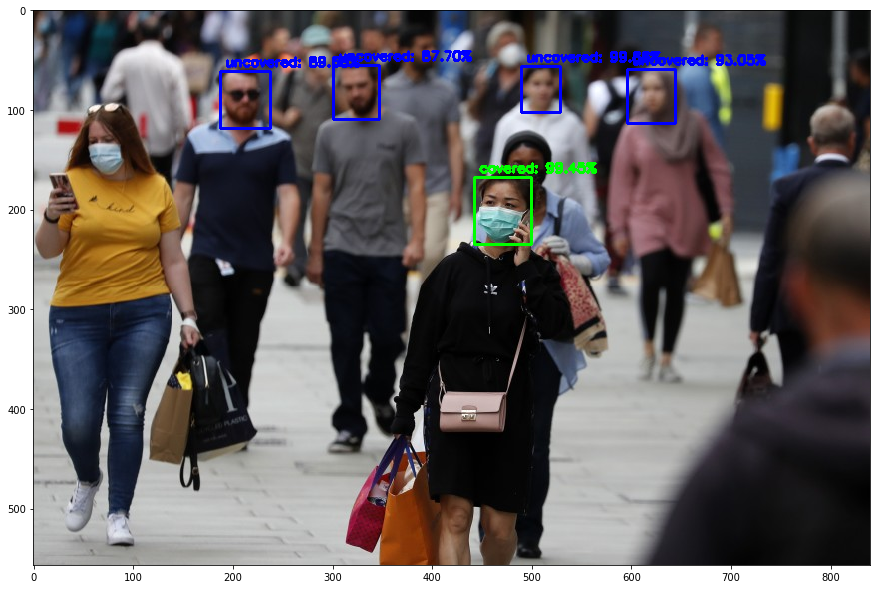

In [59]:
# Test sample image

load_img = cv2.imread("sample_image/90.jpeg")
#load_img = imutils.resize(load_img, width=400)
result = detectMask(load_img, faceDetector_type2, maskDetector,2)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(15,15))
plt.imshow(result)